# Evaluation metrics for text-matcher data, using Middlematch sample



### Data Dictionary note:
Columns in starting CSV: 

	
`Quotation from PDF`  
`Quotation from JSONL full text`  
`Ground truth character indexes`: These are the ground truth character indexes of quotations in JSONL full text.  

Columns to add:  
`Text-matcher character indexes`: These are the character indexes of matches identified by text-matcher  
`Quotation text as detected by text-matcher`   (OPTIONAL)  
`Match-detected`: This column records whether or not text-matcher detected a quotation. Values recorded as either 1 or 0. 1 indicates positive (ie a quotation detected), 0 means a negative, ie no quotation detected.  
`Actual`: This column records the actual (ground truth) classification of a piece of text as a quotation or not.  Values recorded as either 1 or 0: 1 indicates positive (ie a quotation), 0 means a negative, ie not a quotation.  


### Glossary: 
TP (True Positives): A quotation that is correctly identified by text-matcher as a quotation  
TN (True Negatives): Text that is not a quotation, correctly identified by text-matcher as not quotation  
FP (False Posiives): Text that is not a quotation, incorrectly identified by text-matcher as a quotation  
FN (False Negatives): A quotation that is incorrectly identified by text-matcher as not a quotation

**Classification accuracy:** percentage of correctly identified quotes and non-quotes, or overall, how often is the matcher correct? classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)))

 **Recall (or "sensitivity")**: When the actual match is correc, how often is the prediction correct? recall = TP / float(FN + TP)


**Precision (or "specificitiy"):** When a match is detected, how often is that match correct? precision = TP / float(TP + FP)



In [2908]:
#sampleData = articlesWithMatches1960_2015.sample(n=56, random_state=56)
#sampleData['journal'].value_counts(sort=False)

In [2909]:
# We then manually verified false negatives and false positives, true positives and false positives

In [1]:
import re  
import numpy as np #
import pandas as pd
from sklearn import metrics

### Load in our data

In [2]:
sampleData = pd.read_csv('../data/middlemarch-ground-truth-indexes-updated.csv', encoding='utf-8')

In [4]:
#Let's just look at those with IDs
sampleData = sampleData[sampleData['id'].notna()]
sampleData

,id,Author name,Year,Page number,Quotation from PDF,Quotation from JSONL full text,Ground-truth character indexes,Notes
0,Book chapter,“Notes”,2006,p. 533,““The Doctor was more than suspected of having...,NaN,NaN,NaN
1,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 443,"“All of us, grave or light, get our thoughts e...","All of us, grave or light, get our thoughts en...","[14718, 14825]","addition of ""of them"""
2,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 446,"“""known merely as a cluster of signs for \[her...",known merely as a cluster of signs for his nei...,"[64756, 64829]","""\[her\]"" replaced with ""his"", deletion of ""1"""
3,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 450,"“""Rosamond, in fact, was entirely occupied not...","Rosamond, in fact, was entirely occupied not e...","[36183, 36307]","deletion of ""23"""
4,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 452,"“""virtually unknown""”",virtually unknown,"[64738, 64755]",three instances of this quotation
...,...,...,...,...,...,...,...,...
1733,http://www.jstor.org/stable/40549795,DONOGHUE,2006,NaN,driving out to the Campagna,driving out to the Campagna,"[9181, 9208]",found by matcher. scholarly free indirect disc...
1734,http://www.jstor.org/stable/3044863,Doody,1980,NaN,the volumes of polite literature in the bookca...,the volumes of polite literature in the bookca...,"[2811, 2906]","found by matcher. partial match, due to ""volum..."
1735,http://www.jstor.org/stable/3044620,Wilt,1981,NaN,of loving and being loved,of loving and being loved,"[42795, 42820]",found by matcher. scholarly free indirect disc...
1736,http://www.jstor.org/stable/3044620,Wilt,1981,NaN,which no third person,which no third person,"[44271, 44292]",found by matcher. scholarly free indirect disc...


### Remove book chapters

In [5]:
sampleData = sampleData[sampleData['id'] != 'Book chapter']
sampleData

,id,Author name,Year,Page number,Quotation from PDF,Quotation from JSONL full text,Ground-truth character indexes,Notes
1,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 443,"“All of us, grave or light, get our thoughts e...","All of us, grave or light, get our thoughts en...","[14718, 14825]","addition of ""of them"""
2,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 446,"“""known merely as a cluster of signs for \[her...",known merely as a cluster of signs for his nei...,"[64756, 64829]","""\[her\]"" replaced with ""his"", deletion of ""1"""
3,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 450,"“""Rosamond, in fact, was entirely occupied not...","Rosamond, in fact, was entirely occupied not e...","[36183, 36307]","deletion of ""23"""
4,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 452,"“""virtually unknown""”",virtually unknown,"[64738, 64755]",three instances of this quotation
5,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 455,“the world as an udder to feed the supreme self”,they are a taking of the world as an udder to ...,"[49114, 49181]","not enclosed by quotation marks, addition of ""..."
...,...,...,...,...,...,...,...,...
1733,http://www.jstor.org/stable/40549795,DONOGHUE,2006,NaN,driving out to the Campagna,driving out to the Campagna,"[9181, 9208]",found by matcher. scholarly free indirect disc...
1734,http://www.jstor.org/stable/3044863,Doody,1980,NaN,the volumes of polite literature in the bookca...,the volumes of polite literature in the bookca...,"[2811, 2906]","found by matcher. partial match, due to ""volum..."
1735,http://www.jstor.org/stable/3044620,Wilt,1981,NaN,of loving and being loved,of loving and being loved,"[42795, 42820]",found by matcher. scholarly free indirect disc...
1736,http://www.jstor.org/stable/3044620,Wilt,1981,NaN,which no third person,which no third person,"[44271, 44292]",found by matcher. scholarly free indirect disc...


In [6]:
# What rows still ahve NaN ground truth character indexes?
sampleData[sampleData['Ground-truth character indexes'].isna()]

,id,Author name,Year,Page number,Quotation from PDF,Quotation from JSONL full text,Ground-truth character indexes,Notes


In [7]:
sampleData[sampleData['Ground-truth character indexes'].isna()].to_csv('incompletes.csv')

### Remove the rows that students have not completed

In [8]:
sampleData = sampleData[sampleData['Ground-truth character indexes'].notna()]
sampleData

,id,Author name,Year,Page number,Quotation from PDF,Quotation from JSONL full text,Ground-truth character indexes,Notes
1,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 443,"“All of us, grave or light, get our thoughts e...","All of us, grave or light, get our thoughts en...","[14718, 14825]","addition of ""of them"""
2,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 446,"“""known merely as a cluster of signs for \[her...",known merely as a cluster of signs for his nei...,"[64756, 64829]","""\[her\]"" replaced with ""his"", deletion of ""1"""
3,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 450,"“""Rosamond, in fact, was entirely occupied not...","Rosamond, in fact, was entirely occupied not e...","[36183, 36307]","deletion of ""23"""
4,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 452,"“""virtually unknown""”",virtually unknown,"[64738, 64755]",three instances of this quotation
5,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 455,“the world as an udder to feed the supreme self”,they are a taking of the world as an udder to ...,"[49114, 49181]","not enclosed by quotation marks, addition of ""..."
...,...,...,...,...,...,...,...,...
1733,http://www.jstor.org/stable/40549795,DONOGHUE,2006,NaN,driving out to the Campagna,driving out to the Campagna,"[9181, 9208]",found by matcher. scholarly free indirect disc...
1734,http://www.jstor.org/stable/3044863,Doody,1980,NaN,the volumes of polite literature in the bookca...,the volumes of polite literature in the bookca...,"[2811, 2906]","found by matcher. partial match, due to ""volum..."
1735,http://www.jstor.org/stable/3044620,Wilt,1981,NaN,of loving and being loved,of loving and being loved,"[42795, 42820]",found by matcher. scholarly free indirect disc...
1736,http://www.jstor.org/stable/3044620,Wilt,1981,NaN,which no third person,which no third person,"[44271, 44292]",found by matcher. scholarly free indirect disc...


# Add in columns 

## Adding column "Actual"

In [9]:
# Add column "Actual" with value 1 if a quotation character index is present, and 0 to instances where no quotation present

actual = []
for index in range(len(sampleData)):
    charindex1 = sampleData['Ground-truth character indexes'].iloc[index]
    # if no character index is listed, append 0
    if type(charindex1) == float and pd.isna(charindex1):
        actual.append(0)
    else:
        actual.append(1)

sampleData['Actual'] = actual

In [10]:
sampleData.head()

,id,Author name,Year,Page number,Quotation from PDF,Quotation from JSONL full text,Ground-truth character indexes,Notes,Actual
1,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 443,"“All of us, grave or light, get our thoughts e...","All of us, grave or light, get our thoughts en...","[14718, 14825]","addition of ""of them""",1
2,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 446,"“""known merely as a cluster of signs for \[her...",known merely as a cluster of signs for his nei...,"[64756, 64829]","""\[her\]"" replaced with ""his"", deletion of ""1""",1
3,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 450,"“""Rosamond, in fact, was entirely occupied not...","Rosamond, in fact, was entirely occupied not e...","[36183, 36307]","deletion of ""23""",1
4,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 452,"“""virtually unknown""”",virtually unknown,"[64738, 64755]",three instances of this quotation,1
5,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 455,“the world as an udder to feed the supreme self”,they are a taking of the world as an udder to ...,"[49114, 49181]","not enclosed by quotation marks, addition of ""...",1


In [11]:
#Let's see whether our lists are being rendered as numerical lists or not
for item in sampleData['Ground-truth character indexes']:
    print(type(item))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class

### Clean "Ground truth character indexes"

In [12]:
def string_to_list(my_string):
    numeric_list =[]
    try:
        for x in my_string.split(','):
            if x != '[' or x != ']':
                x = x.strip('[]\n')
                numeric_list.append(int(x))
            else:
                pass
        return numeric_list
    except AttributeError:
        pass

In [13]:
# Create a new list called "cleaned_ground_indexes"
cleaned_ground_indexes = []

for item in sampleData['Ground-truth character indexes']:
    cleaned_ground_indexes.append(string_to_list(item))
cleaned_ground_indexes

[[14718, 14825],
 [64756, 64829],
 [36183, 36307],
 [64738, 64755],
 [49114, 49181],
 [64549, 64829],
 [74932, 75029],
 [3228, 3249],
 [3834, 3846],
 [3948, 3985],
 [4020, 4031],
 [4047, 4071],
 [4233, 4352],
 [4976, 4991],
 [5129, 5148],
 [9232, 9254],
 [9290, 9656],
 [10546, 10627],
 [12614, 12698],
 [12719, 12748],
 [12896, 12900],
 [13333, 13345],
 [13431, 13644],
 [13835, 14026],
 [14170, 14203],
 [14217, 14247],
 [14366, 14451],
 [14503, 14511],
 [14938, 15142],
 [15185, 15191],
 [15201, 15281],
 [15655, 15670],
 [15937, 16000],
 [16563, 16714],
 [16867, 16901],
 [16931, 16965],
 [16982, 17067],
 [17146, 17267],
 [17428, 17447],
 [18147, 18165],
 [18234, 18264],
 [18723, 18748],
 [18820, 18887],
 [18985, 19006],
 [19038, 19064],
 [19438, 19618],
 [20185, 20305],
 [20523, 20557],
 [20563, 20568],
 [21147, 21397],
 [21447, 21484],
 [21642, 21727],
 [22025, 22031],
 [22063, 22073],
 [22216, 22228],
 [22255, 22414],
 [22860, 22865],
 [23145, 23261],
 [23282, 23390],
 [23842, 23911],


In [14]:
sampleData['Ground-truth character indexes cleaned'] = cleaned_ground_indexes

In [15]:
sampleData

,id,Author name,Year,Page number,Quotation from PDF,Quotation from JSONL full text,Ground-truth character indexes,Notes,Actual,Ground-truth character indexes cleaned
1,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 443,"“All of us, grave or light, get our thoughts e...","All of us, grave or light, get our thoughts en...","[14718, 14825]","addition of ""of them""",1,"[14718, 14825]"
2,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 446,"“""known merely as a cluster of signs for \[her...",known merely as a cluster of signs for his nei...,"[64756, 64829]","""\[her\]"" replaced with ""his"", deletion of ""1""",1,"[64756, 64829]"
3,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 450,"“""Rosamond, in fact, was entirely occupied not...","Rosamond, in fact, was entirely occupied not e...","[36183, 36307]","deletion of ""23""",1,"[36183, 36307]"
4,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 452,"“""virtually unknown""”",virtually unknown,"[64738, 64755]",three instances of this quotation,1,"[64738, 64755]"
5,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 455,“the world as an udder to feed the supreme self”,they are a taking of the world as an udder to ...,"[49114, 49181]","not enclosed by quotation marks, addition of ""...",1,"[49114, 49181]"
...,...,...,...,...,...,...,...,...,...,...
1733,http://www.jstor.org/stable/40549795,DONOGHUE,2006,NaN,driving out to the Campagna,driving out to the Campagna,"[9181, 9208]",found by matcher. scholarly free indirect disc...,1,"[9181, 9208]"
1734,http://www.jstor.org/stable/3044863,Doody,1980,NaN,the volumes of polite literature in the bookca...,the volumes of polite literature in the bookca...,"[2811, 2906]","found by matcher. partial match, due to ""volum...",1,"[2811, 2906]"
1735,http://www.jstor.org/stable/3044620,Wilt,1981,NaN,of loving and being loved,of loving and being loved,"[42795, 42820]",found by matcher. scholarly free indirect disc...,1,"[42795, 42820]"
1736,http://www.jstor.org/stable/3044620,Wilt,1981,NaN,which no third person,which no third person,"[44271, 44292]",found by matcher. scholarly free indirect disc...,1,"[44271, 44292]"


In [16]:
# Let's check to make sure the indexes were cleaned:
for item in sampleData['Ground-truth character indexes cleaned']:
    print(type(item))

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'li

### Adding in our text-matcher data as a new DataFrame

In [20]:
# Fill this in with the name of the hyperparameter JSON file
hyperparameter_test_name="t2-c3-n2-m3-no-stops"

In [21]:
# Load in the JSON file with our JSTOR articles and data from TextMatcher
# (Note: must have the file 'default.json' in the same directory as this notebook)
df = pd.read_json(f'../data/{hyperparameter_test_name}.json')
df

,creator,datePublished,docSubType,docType,id,identifier,isPartOf,issueNumber,language,outputFormat,...,title,url,volumeNumber,wordCount,numMatches,Locations in A,Locations in B,abstract,keyphrase,subTitle
0,[Rainer Emig],2006-01-01,book-review,article,http://www.jstor.org/stable/41158244,"[{'name': 'issn', 'value': '03402827'}, {'name...",Amerikastudien / American Studies,3,[eng],"[unigram, bigram, trigram]",...,Review Article,http://www.jstor.org/stable/41158244,51,1109,1,"[[130022, 130046]]","[[6851, 6875]]",None,None,None
1,[Martin Green],1970-01-01,book-review,article,http://www.jstor.org/stable/3722819,"[{'name': 'issn', 'value': '00267937'}, {'name...",The Modern Language Review,1,[eng],"[unigram, bigram, trigram]",...,Review Article,http://www.jstor.org/stable/3722819,65,1342,0,[],[],None,None,None
2,[Richard Exner],1982-01-01,book-review,article,http://www.jstor.org/stable/40137021,"[{'name': 'issn', 'value': '01963570'}, {'name...",World Literature Today,1,[eng],"[unigram, bigram, trigram]",...,Review Article,http://www.jstor.org/stable/40137021,56,493,0,[],[],None,None,None
3,[Ruth Evelyn Henderson],1925-10-01,research-article,article,http://www.jstor.org/stable/802346,"[{'name': 'issn', 'value': '00138274'}, {'name...",The English Journal,8,[eng],"[unigram, bigram, trigram, fullText]",...,American Education Week--November 16-22; Some ...,http://www.jstor.org/stable/802346,14,2161,0,[],[],None,None,None
4,[Alan Palmer],2011-12-01,research-article,article,http://www.jstor.org/stable/10.5325/style.45.4...,"[{'name': 'issn', 'value': '00394238'}, {'name...",Style,4,[eng],"[unigram, bigram, trigram]",...,Rejoinder to Response by Marie-Laure Ryan,http://www.jstor.org/stable/10.5325/style.45.4...,45,1127,0,[],[],None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5879,[Michaela Giesenkirchen],2005-10-01,research-article,article,http://www.jstor.org/stable/27747183,"[{'name': 'issn', 'value': '15403084'}, {'name...",American Literary Realism,1,[eng],"[unigram, bigram, trigram]",...,Ethnic Types and Problems of Characterization ...,http://www.jstor.org/stable/27747183,38,7349,1,"[[23799, 24121]]","[[41472, 41793]]",None,None,None
5880,[Leon Botstein],2005-07-01,misc,article,http://www.jstor.org/stable/4123220,"[{'name': 'issn', 'value': '00274631'}, {'name...",The Musical Quarterly,2,[eng],"[unigram, bigram, trigram]",...,On the Power of Music,http://www.jstor.org/stable/4123220,88,1525,0,[],[],None,None,None
5881,[Linda M. Shires],2013-01-01,research-article,article,http://www.jstor.org/stable/24575734,"[{'name': 'issn', 'value': '10601503'}, {'name...",Victorian Literature and Culture,4,[eng],"[unigram, bigram, trigram]",...,"HARDY'S MEMORIAL ART: IMAGE AND TEXT IN ""WESSE...",http://www.jstor.org/stable/24575734,41,10736,1,"[[173657, 173756]]","[[33963, 34061]]",None,None,None
5882,[Edward H. Cohen],1990-07-01,misc,article,http://www.jstor.org/stable/3827815,"[{'name': 'issn', 'value': '00425222'}, {'name...",Victorian Studies,4,[eng],"[unigram, bigram, trigram]",...,Victorian Bibliography for 1989,http://www.jstor.org/stable/3827815,33,81819,0,[],[],None,None,None


In [22]:
# Let's just look at the data for our sampleData dataset
allowed_values = sampleData['id']
df_filtered = df[df['id'].isin(allowed_values)]
df = df_filtered

In [23]:
total_words_in_article_full_texts = df.wordCount.sum()
total_words_in_article_full_texts

350406

In [24]:
df = df[['id', 'Locations in B']]
df

,id,Locations in B
161,http://www.jstor.org/stable/27708593,"[[2880, 2923], [3115, 3222], [8767, 8844], [11..."
269,http://www.jstor.org/stable/2932697,"[[5478, 5552], [12393, 12522], [13904, 14140]]"
277,http://www.jstor.org/stable/3751142,"[[24065, 24348]]"
385,http://www.jstor.org/stable/10.1525/ncl.2001.5...,"[[6213, 6244], [6308, 6493], [6574, 6724], [71..."
436,http://www.jstor.org/stable/3044589,"[[23228, 23641]]"
619,http://www.jstor.org/stable/42827827,"[[3157, 3413], [3971, 4126], [4290, 4636], [48..."
775,http://www.jstor.org/stable/591341,"[[81986, 82529]]"
889,http://www.jstor.org/stable/23539270,"[[21187, 21627]]"
960,http://www.jstor.org/stable/41059781,"[[44181, 44275], [44591, 44663], [44782, 44941]]"
1044,http://www.jstor.org/stable/25733489,"[[7681, 7743], [33384, 33562], [33483, 33562],..."


In [25]:
# Loop over DF to get ID and each individidual match in Locations in B
ids = []
locations_in_b = []

for index in range(len(df)):
    article_id = df['id'].iloc[index]
    for match in df.loc[df['id'] == article_id, 'Locations in B'].item():
        ids.append(article_id)
        locations_in_b.append(match)
        #print(index)
locs_in_b_df = pd.DataFrame(list(zip(ids, locations_in_b)), columns = ['id', 'Locations in B'])

In [26]:
# Let's look at just one example
locs_in_b_df[locs_in_b_df['id'] == 'http://www.jstor.org/stable/41059781']

,id,Locations in B
50,http://www.jstor.org/stable/41059781,"[44181, 44275]"
51,http://www.jstor.org/stable/41059781,"[44591, 44663]"
52,http://www.jstor.org/stable/41059781,"[44782, 44941]"


In [27]:
for i in locs_in_b_df['Locations in B']:
    print(type(i))

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'li

In [28]:
# Define a function that can compare two intervals in the form of listed tuples, eg [x0, x1], [y0,y1]
def overlaps(range1, range2):
    try:
        if len(range1) == 2 and len(range2) == 2:
            return max(range1[0],range2[0]) < min(range1[1],range2[1])
        else:
            return False
    except TypeError:
        return False

In [29]:
overlaps([6308, 6493],[6300, 6724])

True

## Adding column "Text-matcher character indexes" 
This column draws in data from th text matcher output (the dataframe "locs_in_b_df") and aligns text-matcher character indexes with the column "Ground-truth character indexes cleaned"

In [30]:
# Create our "Text-matcher character indexes" column as a blank
sampleData['Text-matcher character indexes'] = ""

In [31]:
# Test to see if IDs are the same AND if overlap AND if we can add a new column with the text-matcher indexes
for item1 in range(len(sampleData)):
    for row in range(len(locs_in_b_df)):
        loc_in_b_index = locs_in_b_df['Locations in B'].iloc[row]
        ground_index = sampleData['Ground-truth character indexes cleaned'].iloc[item1]
        if sampleData['id'].iloc[item1]==locs_in_b_df['id'].iloc[row]:
            if overlaps(ground_index, loc_in_b_index) == True:
                print("TRUE")
                print(sampleData['id'].iloc[item1])
                print(ground_index)
                print(locs_in_b_df['id'].iloc[row])
                print(loc_in_b_index)
                #sampleData['Text-matcher character indexes'] = "" #Ucmomment + run this first, then delete)
                loc_in_b_string = locs_in_b_df['Locations in B'].astype(object).iloc[row]
                sampleData['Text-matcher character indexes'].iloc[item1] = loc_in_b_string
            else:
                print("IDS MATCH but NO OVERLAP!!!")
        else:
            pass

TRUE
http://www.jstor.org/stable/30030019
[14718, 14825]
http://www.jstor.org/stable/30030019
[14718, 14816]
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
TRUE
http://www.jstor.org/stable/30030019
[64756, 64829]
http://www.jstor.org/stable/30030019
[64553, 64816]
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
TRUE
http://www.jstor.org/stable/30030019
[64738, 64755]
http://www.jstor.org/stable/30030019
[64553, 64816]
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
TRUE
http://www.jstor.org/stable/30030019
[64549, 64829]
http://www.jstor.org/stable/30030019
[64553, 64816]
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS 

/Users/sceckert/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
TRUE
http://www.jstor.org/stable/2873139
[13431, 13644]
http://www.jstor.org/stable/2873139
[13434, 13477]
TRUE
http://www.jstor.org/stable/2873139
[13431, 13644]
http://www.jstor.org/stable/2873139
[13482, 13644]
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
ID

IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVE

IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
TRUE
http://www.jstor.org/stable/2873139
[24039, 24209]
http://www.jstor.org/stable/2873139
[24043, 24209]
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!

IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
TRUE
http://www.jstor.org/stable/2873139
[29720, 29758]
http://www.jstor.org/stable/2873139
[29720, 29758]
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!

IDS MATCH but NO OVERLAP!!!
TRUE
http://www.jstor.org/stable/462077
[6609, 6615]
http://www.jstor.org/stable/462077
[6609, 6849]
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
TRUE
http://www.jstor.org/stable/462077
[6623, 6849]
http://www.jstor.org/stable/462077
[6609, 6849]
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
TRUE
http://www.jstor.org/stable/462077
[6939, 7095]
http://www.jstor.org/stable/462077
[6981, 7087]
TRUE
http://www.jstor.org/stable/23099626
[3441, 3721]
http://www.jstor.org/stable/23099626
[3446, 3719]
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
TRUE
http://www.jstor.org/stable/23099626
[5555, 5657]
http://www.jstor.org/stable/23099626
[5560, 5654]
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH b

IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
TRUE
http://www.jstor.org/stable/3044571
[46080, 46634]
http://www.jstor.org/stable/3044571
[46094, 46252]
TRUE
http://www.jstor.org/stable/3044571
[46080, 46634]
http://www.jstor.org/stable/3044571
[46257, 46479]
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
TRUE
http://www.jstor.org/stable/439034
[380, 505]
http://www.jstor.org/stable/439034
[380, 505]
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
TRUE
http://www.jstor.org/stable/439034
[548, 803]
http://www.jstor.org/stable/439034
[552, 802]
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS 

IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
TRUE
http://www.jstor.org/stable/25733489
[33474, 33571]
http://www.jstor.org/stable/25733489
[33384, 33562]
TRUE
http://www.jstor.org/stable/25733489
[33474, 33571]
http://www.jstor.org/stable/25733489
[33483, 33562]
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
TRUE
http://www.jstor.org/stable/25733489
[39444, 39450]
http://www.jstor.org/stable/25733489
[39431, 39531]
I

IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
TRUE
http://www.jstor.org/stable/25733489
[40989, 41055]
http://www.jstor.org/stable/25733489
[40989, 41055]
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLA

IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVE

IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVE

IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVE

IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
TRUE
http://www.jstor.org/stable/2928567
[22123, 23067]
http://www.jstor.org/stable/2928567
[22127, 22861]
TRUE
http://www.jstor.org/stable/2928567
[22123, 23067]
http://www.jstor.org/stable/2928567
[22869, 23064]
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
TRUE
http://www.jstor.org/stable/2928567
[24828, 25257]
http://www.jstor.org/stable/2928567
[24829, 25477]
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
TRUE
http://www.jstor.org/stable/2928567
[25293, 25484]
http://www.jstor.org/stable/2928567
[24829, 25477]
IDS MATCH bu

IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVE

IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
TRUE
http://www.jstor.org/stable/2872038
[16584, 16704]
http://www.jstor.org/stable/2872038
[16587, 16704]
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
TRUE
http://www.jstor.org/stable/2872038
[17643, 1823

IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
TRUE
http://www.jstor.org/stable/2932968
[47672, 48030]
http://www.jstor.org/stable/2932968
[47672, 48024]
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!

IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVE

IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
TRUE
http://www.jstor.org/stable/27708593
[17946, 18149]
http://www.jstor.org/stable/27708593
[17946, 18149]
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLA

IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVE

IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
TRUE
http://www.jstor.org/stable/27708593
[27688, 27717]
http://www.jstor.org/stable/27708593
[26801, 63822]
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLA

http://www.jstor.org/stable/27708593
[26801, 63822]
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
TRUE
http://www.jstor.org/stable/27708593
[35584, 35591]
http://www.jstor.org/stable/27708593
[26801, 63822]

IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
TRUE
http://www.jstor.org/stable/27708593
[46836, 46927]
http://www.jstor.org/stable/27708593
[26801, 63822]
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLA

IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
TRUE
http://www.jstor.org/stable/27708593
[50506, 50541]
http://www.jstor.org/stable/27708593
[26801, 63822]
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLA

IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
TRUE
http://www.jstor.org/stable/3825796
[20828,

IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVE

IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
TRUE
http://www.jstor.org/stable/43028240
[21256, 22063]
http://www.jstor.org/stable/43028240
[21259, 24157]
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
TRUE
http://www.jstor.org/stable/43028240
[22448, 2

TRUE
http://www.jstor.org/stable/42827730
[1078, 1124]
http://www.jstor.org/stable/42827730
[1087, 1124]
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!

IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
TRUE
http://www.jstor.org/stable/40754482
[20488, 21089]
http://www.jstor.org/stable/40754482
[20493, 21089]
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
TRUE
http://www.jstor.org/stable/40754482
[22488, 2

IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVE

IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVE

IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVE

TRUE
http://www.jstor.org/stable/3044620
[25831, 25903]
http://www.jstor.org/stable/3044620
[25831, 25903]
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
TRUE
http://www.jstor.org/stable/27708062
[5106, 5576]
http://www.jstor.org/stable/27708062
[5106, 5412]
TRUE
http://www.jstor.org/stable/27708062
[5106, 5576]
http://www.jstor.org/stable/27708062
[5432, 5608]
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
TRUE
http://www.jstor.org/stable/25733489
[40538, 40576]
http://www.jstor.org/stable/25733489
[40542, 40576]
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but NO OVERLAP!!!
IDS MATCH but 

In [32]:
# Let's check to make sure it worked
sampleData[sampleData['Ground-truth character indexes cleaned'].notna()].head()

,id,Author name,Year,Page number,Quotation from PDF,Quotation from JSONL full text,Ground-truth character indexes,Notes,Actual,Ground-truth character indexes cleaned,Text-matcher character indexes
1,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 443,"“All of us, grave or light, get our thoughts e...","All of us, grave or light, get our thoughts en...","[14718, 14825]","addition of ""of them""",1,"[14718, 14825]","[14718, 14816]"
2,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 446,"“""known merely as a cluster of signs for \[her...",known merely as a cluster of signs for his nei...,"[64756, 64829]","""\[her\]"" replaced with ""his"", deletion of ""1""",1,"[64756, 64829]","[64553, 64816]"
3,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 450,"“""Rosamond, in fact, was entirely occupied not...","Rosamond, in fact, was entirely occupied not e...","[36183, 36307]","deletion of ""23""",1,"[36183, 36307]",
4,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 452,"“""virtually unknown""”",virtually unknown,"[64738, 64755]",three instances of this quotation,1,"[64738, 64755]","[64553, 64816]"
5,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 455,“the world as an udder to feed the supreme self”,they are a taking of the world as an udder to ...,"[49114, 49181]","not enclosed by quotation marks, addition of ""...",1,"[49114, 49181]",


----

### Adding Column "Match-detected" based on "Text-matcher character indexes"
To add in a column called "match detected" we're going to need to check whether there is an entry in the "Text-matcher character indexes" column.

In [33]:
import numpy as np

for row in range(len(sampleData)):
    sampleData['Match-detected'] = np.where(sampleData['Text-matcher character indexes'] != "", 1, 0)

In [34]:
sampleData

,id,Author name,Year,Page number,Quotation from PDF,Quotation from JSONL full text,Ground-truth character indexes,Notes,Actual,Ground-truth character indexes cleaned,Text-matcher character indexes,Match-detected
1,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 443,"“All of us, grave or light, get our thoughts e...","All of us, grave or light, get our thoughts en...","[14718, 14825]","addition of ""of them""",1,"[14718, 14825]","[14718, 14816]",1
2,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 446,"“""known merely as a cluster of signs for \[her...",known merely as a cluster of signs for his nei...,"[64756, 64829]","""\[her\]"" replaced with ""his"", deletion of ""1""",1,"[64756, 64829]","[64553, 64816]",1
3,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 450,"“""Rosamond, in fact, was entirely occupied not...","Rosamond, in fact, was entirely occupied not e...","[36183, 36307]","deletion of ""23""",1,"[36183, 36307]",,0
4,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 452,"“""virtually unknown""”",virtually unknown,"[64738, 64755]",three instances of this quotation,1,"[64738, 64755]","[64553, 64816]",1
5,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 455,“the world as an udder to feed the supreme self”,they are a taking of the world as an udder to ...,"[49114, 49181]","not enclosed by quotation marks, addition of ""...",1,"[49114, 49181]",,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1733,http://www.jstor.org/stable/40549795,DONOGHUE,2006,NaN,driving out to the Campagna,driving out to the Campagna,"[9181, 9208]",found by matcher. scholarly free indirect disc...,1,"[9181, 9208]",,0
1734,http://www.jstor.org/stable/3044863,Doody,1980,NaN,the volumes of polite literature in the bookca...,the volumes of polite literature in the bookca...,"[2811, 2906]","found by matcher. partial match, due to ""volum...",1,"[2811, 2906]",,0
1735,http://www.jstor.org/stable/3044620,Wilt,1981,NaN,of loving and being loved,of loving and being loved,"[42795, 42820]",found by matcher. scholarly free indirect disc...,1,"[42795, 42820]",,0
1736,http://www.jstor.org/stable/3044620,Wilt,1981,NaN,which no third person,which no third person,"[44271, 44292]",found by matcher. scholarly free indirect disc...,1,"[44271, 44292]",,0


### Output a CSV to test in "checking-student-quotation-data.ipynb"

In [36]:
sampleData.to_csv(f"../../../Middlematch/hyperparameter-data/aligned-indexes/middlemarch-ground-truth-indexes-aligned-{hyperparameter_test_name}.csv", encoding="utf-8", index=False)

### Filter out stopwords (Y or N)

In [37]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sceckert/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
# Change below to uncomment and leave in stopwords
#sampleData['Quotation from JSONL full text cleaned'] = sampleData['Quotation from JSONL full text'].\
#apply(lambda x: " ".join(x.lower() for x in str(x).split()))#if x not in stop_words))

In [39]:
# Change below to uncomment and filter out stopwords
sampleData['Quotation from JSONL full text cleaned'] = sampleData['Quotation from JSONL full text'].\
apply(lambda x: " ".join(x.lower() for x in str(x).split() if x not in stop_words))

In [40]:
sampleData

,id,Author name,Year,Page number,Quotation from PDF,Quotation from JSONL full text,Ground-truth character indexes,Notes,Actual,Ground-truth character indexes cleaned,Text-matcher character indexes,Match-detected,Quotation from JSONL full text cleaned
1,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 443,"“All of us, grave or light, get our thoughts e...","All of us, grave or light, get our thoughts en...","[14718, 14825]","addition of ""of them""",1,"[14718, 14825]","[14718, 14816]",1,"all us, grave light, get thoughts entangled me..."
2,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 446,"“""known merely as a cluster of signs for \[her...",known merely as a cluster of signs for his nei...,"[64756, 64829]","""\[her\]"" replaced with ""his"", deletion of ""1""",1,"[64756, 64829]","[64553, 64816]",1,known merely cluster signs neighbour's false s...
3,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 450,"“""Rosamond, in fact, was entirely occupied not...","Rosamond, in fact, was entirely occupied not e...","[36183, 36307]","deletion of ""23""",1,"[36183, 36307]",,0,"rosamond, fact, entirely occupied exactly tert..."
4,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 452,"“""virtually unknown""”",virtually unknown,"[64738, 64755]",three instances of this quotation,1,"[64738, 64755]","[64553, 64816]",1,virtually unknown
5,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 455,“the world as an udder to feed the supreme self”,they are a taking of the world as an udder to ...,"[49114, 49181]","not enclosed by quotation marks, addition of ""...",1,"[49114, 49181]",,0,taking world udder feed supreme self
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1733,http://www.jstor.org/stable/40549795,DONOGHUE,2006,NaN,driving out to the Campagna,driving out to the Campagna,"[9181, 9208]",found by matcher. scholarly free indirect disc...,1,"[9181, 9208]",,0,driving campagna
1734,http://www.jstor.org/stable/3044863,Doody,1980,NaN,the volumes of polite literature in the bookca...,the volumes of polite literature in the bookca...,"[2811, 2906]","found by matcher. partial match, due to ""volum...",1,"[2811, 2906]",,0,volumes polite literature bookcase looked like...
1735,http://www.jstor.org/stable/3044620,Wilt,1981,NaN,of loving and being loved,of loving and being loved,"[42795, 42820]",found by matcher. scholarly free indirect disc...,1,"[42795, 42820]",,0,loving loved
1736,http://www.jstor.org/stable/3044620,Wilt,1981,NaN,which no third person,which no third person,"[44271, 44292]",found by matcher. scholarly free indirect disc...,1,"[44271, 44292]",,0,third person


### Get quotation counts

In [41]:
quote_length = sampleData['Quotation from JSONL full text'].str.split().str.len() 
quote_length.value_counts()

1.0      159
2.0      142
3.0       81
4.0       67
6.0       64
        ... 
88.0       1
92.0       1
281.0      1
314.0      1
153.0      1
Name: Quotation from JSONL full text, Length: 108, dtype: int64

In [42]:
total_words_in_quotations = quote_length.sum()
total_words_in_quotations

18752.0

### Remove quotations shorter than X words (default is 5)

In [43]:
count = sampleData['Quotation from JSONL full text cleaned'].str.split().str.len() 
count

1       12
2        7
3        9
4        2
5        6
        ..
1733     2
1734     9
1735     2
1736     2
1737     4
Name: Quotation from JSONL full text cleaned, Length: 1111, dtype: int64

In [44]:
sampleData['quote_wordcount'] = count

In [45]:
sampleData[(sampleData['Actual'] == 1) & (sampleData['Match-detected'] == 0)]

,id,Author name,Year,Page number,Quotation from PDF,Quotation from JSONL full text,Ground-truth character indexes,Notes,Actual,Ground-truth character indexes cleaned,Text-matcher character indexes,Match-detected,Quotation from JSONL full text cleaned,quote_wordcount
3,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 450,"“""Rosamond, in fact, was entirely occupied not...","Rosamond, in fact, was entirely occupied not e...","[36183, 36307]","deletion of ""23""",1,"[36183, 36307]",,0,"rosamond, fact, entirely occupied exactly tert...",9
5,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 455,“the world as an udder to feed the supreme self”,they are a taking of the world as an udder to ...,"[49114, 49181]","not enclosed by quotation marks, addition of ""...",1,"[49114, 49181]",,0,taking world udder feed supreme self,6
7,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 462,"“""We are all of us born in moral stupidity, ta...","We are all of us born in moral stupidity, taki...","[74932, 75029]",NaN,1,"[74932, 75029]",,0,"we us born moral stupidity, taking world udder...",11
8,http://www.jstor.org/stable/2873139,Andres,1988,p. 854,"“""fragments of heaven”",fragments of heaven,"[3228, 3249]",NaN,1,"[3228, 3249]",,0,fragments heaven,2
9,http://www.jstor.org/stable/2873139,Andres,1988,p. 854,"“""sudden light""”",sudden light,"[3834, 3846]",NaN,1,"[3834, 3846]",,0,sudden light,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1733,http://www.jstor.org/stable/40549795,DONOGHUE,2006,NaN,driving out to the Campagna,driving out to the Campagna,"[9181, 9208]",found by matcher. scholarly free indirect disc...,1,"[9181, 9208]",,0,driving campagna,2
1734,http://www.jstor.org/stable/3044863,Doody,1980,NaN,the volumes of polite literature in the bookca...,the volumes of polite literature in the bookca...,"[2811, 2906]","found by matcher. partial match, due to ""volum...",1,"[2811, 2906]",,0,volumes polite literature bookcase looked like...,9
1735,http://www.jstor.org/stable/3044620,Wilt,1981,NaN,of loving and being loved,of loving and being loved,"[42795, 42820]",found by matcher. scholarly free indirect disc...,1,"[42795, 42820]",,0,loving loved,2
1736,http://www.jstor.org/stable/3044620,Wilt,1981,NaN,which no third person,which no third person,"[44271, 44292]",found by matcher. scholarly free indirect disc...,1,"[44271, 44292]",,0,third person,2


In [86]:
# Change this with each iteration to reflect the lowest detectable threshold for a given hyperparameter setting
sampleDataFiltered = sampleData[sampleData['quote_wordcount'] >=4]
sampleDataFiltered.head()

,id,Author name,Year,Page number,Quotation from PDF,Quotation from JSONL full text,Ground-truth character indexes,Notes,Actual,Ground-truth character indexes cleaned,Text-matcher character indexes,Match-detected,Quotation from JSONL full text cleaned,quote_wordcount
1,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 443,"“All of us, grave or light, get our thoughts e...","All of us, grave or light, get our thoughts en...","[14718, 14825]","addition of ""of them""",1,"[14718, 14825]","[14718, 14816]",1,"all us, grave light, get thoughts entangled me...",12
2,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 446,"“""known merely as a cluster of signs for \[her...",known merely as a cluster of signs for his nei...,"[64756, 64829]","""\[her\]"" replaced with ""his"", deletion of ""1""",1,"[64756, 64829]","[64553, 64816]",1,known merely cluster signs neighbour's false s...,7
3,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 450,"“""Rosamond, in fact, was entirely occupied not...","Rosamond, in fact, was entirely occupied not e...","[36183, 36307]","deletion of ""23""",1,"[36183, 36307]",,0,"rosamond, fact, entirely occupied exactly tert...",9
5,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 455,“the world as an udder to feed the supreme self”,they are a taking of the world as an udder to ...,"[49114, 49181]","not enclosed by quotation marks, addition of ""...",1,"[49114, 49181]",,0,taking world udder feed supreme self,6
6,http://www.jstor.org/stable/30030019,Albrecht,2006,p. 459,"“""For surely all must admit that a man may be ...",For surely all must admit that a man may be pu...,"[64549, 64829]",NaN,1,"[64549, 64829]","[64553, 64816]",1,"for surely must admit man may puffed belauded,...",30


## Adding new rows w/ textmatcher indexes NOT in ground truth

In [87]:
# Let's create a list of just the text-matcher character indexes in sampleData, called "cleaned_text_matcher_indexes"
cleaned_text_matcher_indexes = []

for item in sampleData['Text-matcher character indexes']:
    if type(item) == list:
        cleaned_text_matcher_indexes.append(item)
    else:
        pass
cleaned_text_matcher_indexes

[[14718, 14816],
 [64553, 64816],
 [64553, 64816],
 [64553, 64816],
 [9299, 9639],
 [10539, 10627],
 [13482, 13644],
 [22259, 22414],
 [23149, 23390],
 [23149, 23390],
 [24043, 24209],
 [24768, 24831],
 [24936, 24970],
 [25048, 25134],
 [25454, 25516],
 [26244, 26404],
 [26948, 26991],
 [28000, 28285],
 [29358, 29438],
 [29720, 29758],
 [29933, 29973],
 [30687, 31190],
 [30687, 31190],
 [31237, 31340],
 [24065, 24348],
 [4417, 4482],
 [6609, 6849],
 [6609, 6849],
 [6981, 7087],
 [3446, 3719],
 [5560, 5654],
 [15159, 15448],
 [8861, 9008],
 [15159, 15448],
 [16824, 16871],
 [25643, 25862],
 [26135, 26284],
 [28018, 28102],
 [28885, 29096],
 [28885, 29096],
 [29741, 29822],
 [46257, 46479],
 [380, 505],
 [552, 802],
 [2335, 2713],
 [7681, 7743],
 [33384, 33562],
 [33483, 33562],
 [39431, 39531],
 [35447, 35889],
 [38802, 38829],
 [38956, 39121],
 [39431, 39531],
 [39431, 39531],
 [40989, 41055],
 [41300, 41500],
 [41666, 41809],
 [42065, 42220],
 [42884, 43222],
 [43592, 43652],
 [8092, 

#### Identify which text-matcher character index ranges are NOT yet represented in cleaned_text_matcher_indexes

In [88]:
# create a new dataframe (data_to_append_df) of ids and text matcher character indexes 
# by looping over the output of text-matcher and comparing it with the text-matcher indexes aligned in sampleData
ids_to_add = []
indexes_to_add = []

for item in range(len(locs_in_b_df)):
    if locs_in_b_df['Locations in B'].iloc[item] not in cleaned_text_matcher_indexes:
        ids_to_add.append(locs_in_b_df['id'].iloc[item])
        indexes_to_add.append(locs_in_b_df['Locations in B'].iloc[item])
indexes_to_add
data_to_append_df = pd.DataFrame(list(zip(ids_to_add, indexes_to_add)), columns = ['id', 'Text-matcher character indexes'])

In [89]:
# Add a new column "actual" for this data to append. We'll then
data_to_append_df['Actual'] = 0

In [90]:
# check if overlap with ground truth indexes. 
# if so, change value of "Actual" at that location to 1
# This helps deal with quotations that are detected as two quotes.
for item1 in range(len(data_to_append_df)):
    for row in range(len(sampleData)):
        data_to_append_index = data_to_append_df['Text-matcher character indexes'].iloc[item1]
        ground_index = sampleData['Ground-truth character indexes cleaned'].iloc[row]
        if sampleData['id'].iloc[row]==data_to_append_df['id'].iloc[item1]:
            if overlaps(ground_index, data_to_append_index) == True:
                print("TRUE")
                print(sampleData['id'].iloc[row])
                print(ground_index)
                print(data_to_append_df['id'].iloc[item1])
                print(data_to_append_index)
                data_to_append_df['Actual'].iloc[item1] = 1
                #loc_in_b_string = locs_in_b_df['Locations in B'].astype(object).iloc[row]
                # sampleData['Text-matcher character indexes'].iloc[item1] = loc_in_b_string
            else:
                pass
        else:
            pass

TRUE
http://www.jstor.org/stable/27708593
[17390, 17571]
http://www.jstor.org/stable/27708593
[17390, 17415]
TRUE
http://www.jstor.org/stable/27708593
[17390, 17571]
http://www.jstor.org/stable/27708593
[17458, 17495]
TRUE
http://www.jstor.org/stable/27708593
[20922, 21217]
http://www.jstor.org/stable/27708593
[20922, 20962]
TRUE
http://www.jstor.org/stable/27708593
[20922, 21217]
http://www.jstor.org/stable/27708593
[20977, 21019]
TRUE
http://www.jstor.org/stable/27708593
[25489, 25770]
http://www.jstor.org/stable/27708593
[25492, 25626]
TRUE
http://www.jstor.org/stable/10.1525/ncl.2001.56.2.160
[6300, 6724]
http://www.jstor.org/stable/10.1525/ncl.2001.56.2.160
[6308, 6493]
TRUE
http://www.jstor.org/stable/42827827
[6104, 6614]
http://www.jstor.org/stable/42827827
[6110, 6319]
TRUE
http://www.jstor.org/stable/25088885
[4994, 5886]
http://www.jstor.org/stable/25088885
[4998, 5809]


/Users/sceckert/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


TRUE
http://www.jstor.org/stable/3044571
[46080, 46634]
http://www.jstor.org/stable/3044571
[46094, 46252]
TRUE
http://www.jstor.org/stable/3044863
[47889, 48594]
http://www.jstor.org/stable/3044863
[47907, 48048]
TRUE
http://www.jstor.org/stable/3044863
[47889, 48594]
http://www.jstor.org/stable/3044863
[48064, 48304]
TRUE
http://www.jstor.org/stable/3044863
[48989, 49857]
http://www.jstor.org/stable/3044863
[49127, 49236]
TRUE
http://www.jstor.org/stable/3044863
[48989, 49857]
http://www.jstor.org/stable/3044863
[49250, 49330]
TRUE
http://www.jstor.org/stable/43028240
[678, 1435]
http://www.jstor.org/stable/43028240
[678, 1188]
TRUE
http://www.jstor.org/stable/27708062
[5106, 5576]
http://www.jstor.org/stable/27708062
[5106, 5412]
TRUE
http://www.jstor.org/stable/437748
[16764, 16871]
http://www.jstor.org/stable/437748
[16764, 16815]
TRUE
http://www.jstor.org/stable/437748
[27900, 28122]
http://www.jstor.org/stable/437748
[27900, 28012]
TRUE
http://www.jstor.org/stable/2928567
[22123

In [91]:
# Add a new column, indicating that these were all matches
data_to_append_df['Match-detected'] = 1
# Add a new column, indicating that there were no corresponding ground-truth character indexes

In [92]:
data_to_append_df

,id,Text-matcher character indexes,Actual,Match-detected
0,http://www.jstor.org/stable/27708593,"[17390, 17415]",1,1
1,http://www.jstor.org/stable/27708593,"[17458, 17495]",1,1
2,http://www.jstor.org/stable/27708593,"[20922, 20962]",1,1
3,http://www.jstor.org/stable/27708593,"[20977, 21019]",1,1
4,http://www.jstor.org/stable/27708593,"[25492, 25626]",1,1
5,http://www.jstor.org/stable/10.1525/ncl.2001.5...,"[6308, 6493]",1,1
6,http://www.jstor.org/stable/42827827,"[6110, 6319]",1,1
7,http://www.jstor.org/stable/25088885,"[4998, 5809]",1,1
8,http://www.jstor.org/stable/3044571,"[46094, 46252]",1,1
9,http://www.jstor.org/stable/3044863,"[47907, 48048]",1,1


In [93]:
data_to_append_df[data_to_append_df['Actual']== 0].to_csv(f'../../../Middlematch/hyperparameter-data/text-matcher-misclassifications/text-matcher-misclassifications-{hyperparameter_test_name}.csv')

In [94]:
sampleDataFiltered = sampleDataFiltered.append(data_to_append_df, ignore_index=True)
sampleDataFiltered

,id,Author name,Year,Page number,Quotation from PDF,Quotation from JSONL full text,Ground-truth character indexes,Notes,Actual,Ground-truth character indexes cleaned,Text-matcher character indexes,Match-detected,Quotation from JSONL full text cleaned,quote_wordcount
0,http://www.jstor.org/stable/30030019,Albrecht,2006.0,p. 443,"“All of us, grave or light, get our thoughts e...","All of us, grave or light, get our thoughts en...","[14718, 14825]","addition of ""of them""",1,"[14718, 14825]","[14718, 14816]",1,"all us, grave light, get thoughts entangled me...",12.0
1,http://www.jstor.org/stable/30030019,Albrecht,2006.0,p. 446,"“""known merely as a cluster of signs for \[her...",known merely as a cluster of signs for his nei...,"[64756, 64829]","""\[her\]"" replaced with ""his"", deletion of ""1""",1,"[64756, 64829]","[64553, 64816]",1,known merely cluster signs neighbour's false s...,7.0
2,http://www.jstor.org/stable/30030019,Albrecht,2006.0,p. 450,"“""Rosamond, in fact, was entirely occupied not...","Rosamond, in fact, was entirely occupied not e...","[36183, 36307]","deletion of ""23""",1,"[36183, 36307]",,0,"rosamond, fact, entirely occupied exactly tert...",9.0
3,http://www.jstor.org/stable/30030019,Albrecht,2006.0,p. 455,“the world as an udder to feed the supreme self”,they are a taking of the world as an udder to ...,"[49114, 49181]","not enclosed by quotation marks, addition of ""...",1,"[49114, 49181]",,0,taking world udder feed supreme self,6.0
4,http://www.jstor.org/stable/30030019,Albrecht,2006.0,p. 459,"“""For surely all must admit that a man may be ...",For surely all must admit that a man may be pu...,"[64549, 64829]",NaN,1,"[64549, 64829]","[64553, 64816]",1,"for surely must admit man may puffed belauded,...",30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603,http://www.jstor.org/stable/3826242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,"[17342, 17509]",1,NaN,NaN
604,http://www.jstor.org/stable/3826242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,"[44822, 44900]",1,NaN,NaN
605,http://www.jstor.org/stable/2873139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,"[13434, 13477]",1,NaN,NaN
606,http://www.jstor.org/stable/2873139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,"[26687, 26837]",1,NaN,NaN


----

In [95]:
sampleDataFiltered['Actual'].value_counts()

1    608
Name: Actual, dtype: int64

In [96]:
# Calculate the prevalence, estimating the percentage of corpus that is label 1 (a quotation)
print("Percentage of corpus that is Middlemarch quotations:")
print(total_words_in_quotations / total_words_in_article_full_texts)

Percentage of corpus that is Middlemarch quotations:
0.05351506538130055


In [97]:
# Calculate the prevalence, estimating the percentage of corpus that is label 0 (not a quotation)
print("Percentage of corpus that is NOT Middlemarch quotations:")
print(1 - (total_words_in_quotations / total_words_in_article_full_texts))

Percentage of corpus that is NOT Middlemarch quotations:
0.9464849346186994


In [98]:
# What's the number of True Positives in our sample data?
number_of_True_Positives = sampleDataFiltered[sampleDataFiltered['Match-detected'] == 1].Actual.count()
number_of_True_Positives 

271

In [99]:
# What's the number (roughly) of True Negatives in our sample data
number_of_True_Negatives = round(number_of_True_Positives  / (total_words_in_quotations / total_words_in_article_full_texts))
number_of_True_Negatives

5064

In [100]:
# What's the number (roughly) of False Positives in our sample data
number_of_False_Positives = sampleDataFiltered[(sampleDataFiltered['Actual'] == 0) & (sampleDataFiltered['Match-detected'] == 1)].Actual.count()
number_of_False_Positives

0

In [101]:
number_of_False_Negatives = sampleDataFiltered[(sampleDataFiltered['Actual'] == 1) & (sampleDataFiltered['Match-detected'] == 0)].Actual.count()
number_of_False_Negatives

337

In [102]:
# Print results to file
with open(f"../../../Middlematch/hyperparameter-data/evaluation-metrics/{hyperparameter_test_name}-report.txt", "a") as f:
    print(f"Number of True Positives: {number_of_True_Positives}\n", file=f)
    print(f"Number of True Negatives: {number_of_True_Negatives}\n", file=f)
    print(f"Number of False Positives (ie misclassifications): {number_of_False_Positives}\n", file=f)
    print(f"Number of False Negatives (ie missed quotations): {number_of_False_Negatives}\n", file=f)

In [103]:
actual_tn = []
match_detected_tn = []
for i in range(0,number_of_True_Negatives):
    actual_tn.append(0)
    match_detected_tn.append(0)


In [104]:
true_negatives_estimation_df = pd.DataFrame(list(zip(actual_tn, match_detected_tn)), columns = ['Actual', 'Match-detected'])

In [105]:
sampleDataFiltered = sampleDataFiltered.append(true_negatives_estimation_df, ignore_index=True)
sampleDataFiltered['Actual'].value_counts()

0    5064
1     608
Name: Actual, dtype: int64

In [106]:
text_matcher_predicted_classification = sampleDataFiltered['Match-detected']
actual_match_classification = sampleDataFiltered['Actual']

In [107]:
def one_boot(*data_args):
    """Usage: (t, p) = one_boot(true, pred) with true, pred, t, p arrays of same length
    """
    length = len(data_args[0])
    index = np.random.randint(0, length, size=length)  # apply same sampled index to all args:
    return [ pd.Series(arg.values[index], name=arg.name)  # .reset_index() is slower
             if isinstance(arg, pd.Series) else arg[index]   for  arg in data_args
           ]

### Define our functions for calculating performance metrics
Adapted from David B Rosen's ['How to calculate confidence intervals for performance metrics in Machine Learning using an automatic bootstrap method'](https://towardsdatascience.com/get-confidence-intervals-for-any-model-performance-metrics-in-machine-learning-f9e72a3becb2)

Here we're going to calculate the "recall" and "specificity" using sklearn


**Classification accuracy:** percentage of correctly identified quotes and non-quotes, or overall, how often is the matcher correct? classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)))

 **Recall (or "sensitivity")**: When the actual match is correc, how often is the prediction correct? recall = TP / float(FN + TP)


**Precision (or "specificitiy"):** When a match is detected, how often is that match correct? precision = TP / float(TP + FP)


In [108]:
# What our precision score should be (Nonbootstrapped)
print("Precision score (not yet bootstrapped):")
number_of_True_Positives/(number_of_True_Positives + number_of_False_Positives)

Precision score (not yet bootstrapped):


1.0

In [109]:
# What our recall score should be (Nonbootstrapped)
print("Recall score (not yet bootstrapped):")
number_of_True_Positives/(number_of_True_Positives + number_of_False_Negatives)

Recall score (not yet bootstrapped):


0.4457236842105263

In [110]:
# actual_match_classification is our actual/true test set target values
# text_matcher_predicted_classification is the predicted classification

def specificity_score(true, pred, **kwargs):
    """sklearn-compat Specificity metric func for binary: 1=positive classification, 0=negative classification
    """
    return metrics.recall_score(1 - pd.Series(true), 1 - pd.Series(pred), **kwargs)
specificity_score.__name__ = "Specificity (Precision)"
def calc_metrics(metrics, *data_args):
    """Return a list of calculated values for each metric applied to *data_args
    where metrics is a metric func or iterable of funcs e.g. [m1, m2, m3, m4]
    """
    metrics=_fix_metrics(metrics)
    mname = metrics.__name__ if hasattr(metrics, '__name__') else "Metric"
    return pd.Series\
     ([m(*data_args) for m in metrics], index=[_metric_name(m) for m in metrics], name=mname)
def _metric_name(metric):  # use its prettified __name__
    name = re.sub(' score$', '', metric.__name__.replace('_',' ').strip())
    return name.title() if name.lower()==name else name
def _fix_metrics(metrics_): # allow for single metric func or any iterable of metric funcs
    if callable(metrics_): metrics_=[metrics_]  # single metric func to list of one
    return pd.Series(metrics_)  # in case iterable metrics_ is generator, generate & store

In [111]:
specificity_score(actual_match_classification, text_matcher_predicted_classification)

1.0

In [112]:
met=[ metrics.recall_score, specificity_score, 
      metrics.balanced_accuracy_score
    ]
calc_metrics(met, actual_match_classification, text_matcher_predicted_classification)

Recall                     0.445724
Specificity (Precision)    1.000000
Balanced Accuracy          0.722862
Name: Metric, dtype: float64

In [113]:
import tqdm  # progress bar
def trange(iterable):  # narrower progress bar so it won't wrap
    return tqdm.trange(iterable, bar_format="{l_bar}{bar:30}{r_bar}{bar:-10b}")
def raw_metric_samples(metrics, *data_args, nboots):
    """Return dataframe containing metric(s) for nboots boot sample datasets
    where metrics is a metric func or iterable of funcs e.g. [m1, m2, m3]
    """
    metrics=_fix_metrics(metrics)
    cols=[ calc_metrics(metrics, *boot_data)   for boot_data  in _boot_generator\
           (*data_args, nboots=nboots)  if boot_data[0].nunique() >1  # >1 for log Loss, ROC
         ]#end of list comprehension
    return pd.DataFrame\
      ( {iboot: col for iboot,col in enumerate(cols)}#end of dict comprehension
      ).rename_axis("Boot", axis="columns").rename_axis(cols[0].name)
def _boot_generator(*data_args, nboots): #return Gener of boot sampl datasets, not huge list!
    return (one_boot(*data_args) for _ in trange(nboots)) # generator expression

In [114]:
np.random.seed(13)
raw_metric_samples(met, actual_match_classification, text_matcher_predicted_classification, 
          nboots=7).style.format('{:.2%}')  #optional #style

100%|██████████████████████████████| 7/7 [00:00<00:00, 90.79it/s]


Boot,0,1,2,3,4,5,6
Metric,,,,,,,
Recall,43.49%,44.91%,42.57%,44.14%,44.37%,46.40%,42.63%
Specificity (Precision),100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%
Balanced Accuracy,71.75%,72.46%,71.28%,72.07%,72.19%,73.20%,71.31%


In [115]:
raw_metric_samples(met, actual_match_classification, text_matcher_predicted_classification, 
          nboots=7).to_csv(f"../../../Middlematch/hyperparameter-data/evaluation-metrics/{hyperparameter_test_name}-raw-metric-evaluation-score.csv")

100%|██████████████████████████████| 7/7 [00:00<00:00, 94.00it/s]


In [116]:
DFLT_ALPHA = 0.05     # MIN_BOOTS_IN_1TAIL includes tail boundary:
MIN_BOOTS_IN_1TAIL=11 # North et al.:10; Davidson&MacK ".05-->399"==>11, ".01-->1499"==>9
MAX_ALPHA = 0.40 # Make it .25 or .20?  Min boots formula dubious even at .40 or .25?

# Formula: boots_in_1tail = (nboots - 1) * (0.5*alpha) + 1 ; (0.5*alpha is size of 1 tail)
# E.g. nboots=6,alpha=0.40 (confid level =.60). With vals X[0] to X[5] sorted, quantiles are:
#   0.0 --> X[0]  (first of 2 in lower tail)
#   0.2 --> X[1]  interval lower  (0.5*alpha gives 0.2) (2nd of 2 in lower tail)
#   0.4 --> X[2]
#   0.6 --> X[3]
#   0.8 --> X[4]  interval upper  (1 - 0.5*alpha gives 0.8) (2nd of 2 in upper tail)
#   1.0 --> X[5]  (first of 2 in upper tail)
# so boots_in_1tail is (6-1)0.5*0.40+1 gives 2 per tail: X[0],X[1] in lowr, X[4],X[5] in uppr
def _min_nboots_from(alpha): # Calcul. using this formula (from abov), solved for min_nboots: 
                             # MIN_BOOTS_IN_1TAIL = (min_nboots - 1) * (0.5*alpha) + 1
    return int(np.ceil((MIN_BOOTS_IN_1TAIL - 1)/(0.5*alpha) + 1)) 
def _min_alpha_from(nboots): # Calc using this formula (frm above), but solved for min_alpha: 
                             # MIN_BOOTS_IN_1TAIL = (nboots - 1) * (0.5*min_alpha) + 1
    return 2 * (MIN_BOOTS_IN_1TAIL - 1) / (nboots - 1)
MIN_NBOOTS = _min_nboots_from(MAX_ALPHA)

def get_alpha_nboots(alpha=DFLT_ALPHA, nboots=None):
    """Return (alpha, nboots) with default nboots, applying MIN_NBOOTS & min alpha for nboots.
    """
    if alpha > MAX_ALPHA and (0 < (1-alpha) <= MAX_ALPHA):
        raise ValueError(f'alpha={alpha} > 0.5. Did you mean alpha={1-alpha:.9g}?')
    elif not (0 < alpha <= MAX_ALPHA):
        raise ValueError(f'alpha={alpha} is outside allowed range: 0 < alpha <= {MAX_ALPHA}')
    if pd.isna(nboots):   # by dflt use calculated min nboots for given alpha:
        nboots = _min_nboots_from(alpha)
    if int(nboots) != nboots: raise ValueError(f"nboots={nboots} isn't an integer")
    nboots = max(int(nboots), MIN_NBOOTS)  # apply min to a specified OR calculated nboots
    alpha = max(alpha, _min_alpha_from(nboots))  # apply min alpha for final nboots
    return (alpha, nboots)  # tuple of possibly-modified args

In [117]:
g = get_alpha_nboots 
pd.DataFrame( [ g(0.40), g(0.20, None), g(0.10), g(), g(alpha=0.02), 
                g(alpha=0.01, nboots=None), g(0.005, nboots=None)
              ], columns=['alpha', 'default nboots']
            ).set_index('alpha')

,default nboots
alpha,
0.400,51
0.200,101
0.100,201
0.050,401
0.020,1001
0.010,2001
0.005,4001


In [118]:
req=[(0.01,3000), (0.01,401), (0.01,2)]
out=[get_alpha_nboots(*args) for args in req]
mydf = lambda x: pd.DataFrame(x, columns=['alpha', 'nboots'])
pd.concat([mydf(req),mydf(out)],axis=1, keys=('Requested','Using'))

Requested        Using       
      alpha nboots alpha nboots
0      0.01   3000  0.01   3000
1      0.01    401  0.05    401
2      0.01      2  0.40     51

In [119]:
import matplotlib, matplotlib.ticker as mtick
def metric_boot_histogram(metric, *data_args, alpha=DFLT_ALPHA, nboots=None):
    """Plot histogram w/ lines for 1 observed metric & its confidence interval.
    """
    alpha, nboots = get_alpha_nboots(alpha, nboots) # 1-row df 2 series:
    series = raw_metric_samples(metric, *data_args, nboots=nboots).iloc[0,:]
    nboots=len(series) # in case some failed
    (lo, hi) = series.quantile([0.5*alpha, 1 - 0.5*alpha])
    matplotlib.rcParams["figure.dpi"] = 250
    ax = series.hist(bins=50, figsize=(7, 2.5), alpha=0.4, edgecolor='white')
    showing = f", showing {100*(1-alpha):.4g}% Confidence Interval"
    ax.set_title(f"Histogram of {nboots} boot results" + showing)
    ax.set_xlabel(series.name)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
    for x in lo, metric(*data_args), hi:
        ax.plot([x, x], [0, nboots*.07], lw=2.5)

100%|██████████████████████████████| 401/401 [00:02<00:00, 192.98it/s]


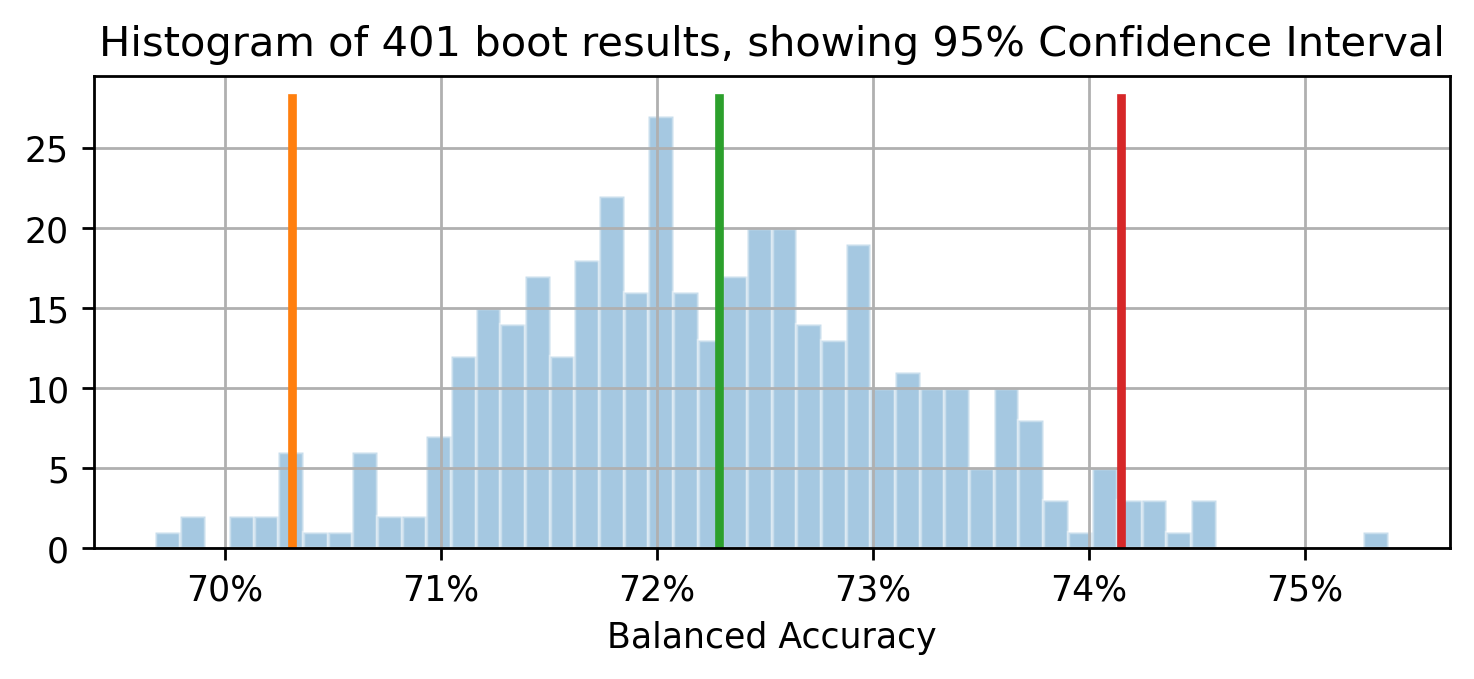

In [120]:
np.random.seed(13)
metric_boot_histogram\
  (metrics.balanced_accuracy_score, actual_match_classification, text_matcher_predicted_classification)

In [121]:
def ci_auto( metrics, *data_args, alpha=DFLT_ALPHA, nboots=None):
    """Return Pandas data frame of bootstrap confidence intervals. 
    PARAMETERS:
    metrics : a metric func or iterable of funcs e.g. [m1, m2, m3]
    data_args : 1+ (often 2, e.g. ytrue,ypred) iterables for metric 
    alpha: = 1 - confidence level; default=0.05 i.e. confidence=0.95
    nboots (optional!): # boots drawn from data; dflt None ==> calc. from alpha
    """
    alpha, nboots = get_alpha_nboots(alpha, nboots)
    metrics=_fix_metrics(metrics)
    result=raw_metric_samples(metrics, *data_args, nboots=nboots)
    nb=result.shape[1]  # num boots we ended up with
    if nb<nboots:
        t = f'Note: {nboots-nb} boot sample datasets dropped\n'
        print(t + f'(out of {nboots}) because all vals were same in 1st data arg.')
    result = result.apply(lambda row: row.quantile([0.5*alpha, 1 - 0.5*alpha]), axis=1)
    result.columns = [f'{x*100:.4g}%ile' for x in (0.5*alpha, 1 - 0.5*alpha)]
    result.insert(0, "Observed", calc_metrics(metrics, *data_args)) #col for obs (point estim)
    return result.rename_axis(f"%ile for {nb} Boots", axis="columns")

In [122]:
np.random.seed(13)
ci_auto( met, actual_match_classification, text_matcher_predicted_classification
       ).style.format('{:.2%}')

100%|██████████████████████████████| 401/401 [00:04<00:00, 89.87it/s]


%ile for 401 Boots,Observed,2.5%ile,97.5%ile
Metric,,,
Recall,44.57%,40.62%,48.29%
Specificity (Precision),100.00%,100.00%,100.00%
Balanced Accuracy,72.29%,70.31%,74.15%


In [123]:
ci_auto( met, actual_match_classification, text_matcher_predicted_classification
       ).to_csv(f"../../../Middlematch/hyperparameter-data/evaluation-metrics/{hyperparameter_test_name}-confidence-interval.csv")

100%|██████████████████████████████| 401/401 [00:04<00:00, 95.31it/s]
